In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

num_bins = 10

In [2]:
col_grant = "basic" # choices: basic, targeted, concentration
epsilon = 1.0 # choices: 0.1, 0.5, 1.0

In [3]:
with open("./sampling_results/results_nondp.pkl", 'rb') as handle:
    results_sampling = pickle.load(handle)

path_laplace = "./sampling_results/results_laplace_eps{}.pkl".format(epsilon)
with open(path_laplace, 'rb') as handle:
    results_laplace = pickle.load(handle)

path_gaussian = "./sampling_results/results_gaussian_eps{}.pkl".format(epsilon)
with open(path_gaussian, 'rb') as handle:
    results_gaussian = pickle.load(handle)

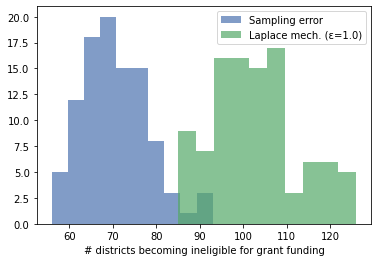

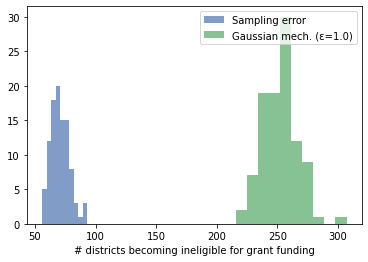

In [4]:
# Number ineligible

quantile = 'sum'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_eligible_{}".format(col_grant)].values

y = df_laplace["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_eligible_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("# districts becoming ineligible for grant funding")
plt.legend(loc='upper right')
plt.show()

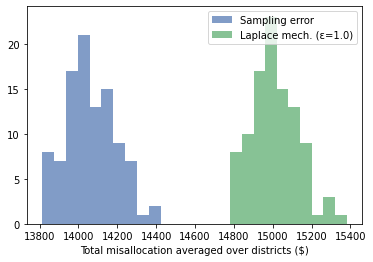

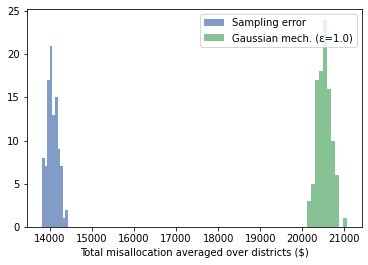

In [5]:
# Average misallocation

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format(col_grant)].values

y = df_laplace["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_grant_{}".format(col_grant)].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

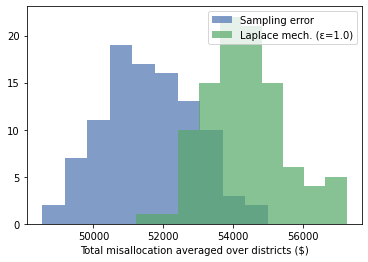

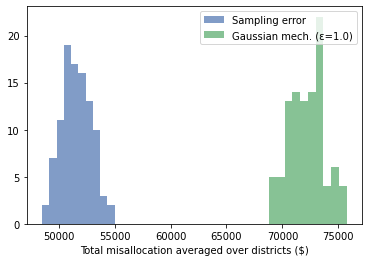

In [6]:
# Average misallocation (sum of all three grant types)

quantile = 'mean'
df_sampling = results_sampling[quantile]
df_laplace = results_laplace[quantile]
df_gaussian = results_gaussian[quantile]

x = df_sampling["diff_grant_{}".format('basic')].values + \
    df_sampling["diff_grant_{}".format('targeted')].values + \
    df_sampling["diff_grant_{}".format('concentration')].values

y = df_laplace["diff_grant_{}".format('basic')].values + \
    df_laplace["diff_grant_{}".format('targeted')].values + \
    df_laplace["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Laplace mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()

y = df_gaussian["diff_grant_{}".format('basic')].values + \
    df_gaussian["diff_grant_{}".format('targeted')].values + \
    df_gaussian["diff_grant_{}".format('concentration')].values
plt.hist(x, bins=num_bins, label="Sampling error", alpha=0.7)
plt.hist(y, bins=num_bins, label="Gaussian mech. (ε={})".format(epsilon), alpha=0.7)
plt.xlabel("Total misallocation averaged over districts ($)")
plt.legend(loc='upper right')
plt.show()